### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index #statistics : UnDef,mean,std,SortedVals,low100,high100,low1000,high1000,eigval,eigvec,covariance matrix
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12740
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     6|[40 56 30 54 40 5...|1910.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|    21|[80 C9 30 D4 00 4...|1911.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     2|[E0 D0 80 C9 E0 D...|1912.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     5|[80 C9 00 C6 30 5...|1913.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     0|[80 CD 40 CC 00 4...|1914.0|SSSSBBBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00299113')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect() # measurement of each year for a particular station for PRCP
T=np.vstack(rows) # stacking row wise
T=T/10  # scaling to make the temperature be in centingrates
shape(T)
#print T[0]

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00299113'
44 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2449.1| 36.0333|-105.8167|       PRCP|USC00299113|     0|[F0 57 00 54 00 5...|1910.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       PRCP|USC00299113|    28|[00 7E 00 7E 00 7...|1911.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       PRCP|USC00299113|     1|[00 00 00 00 00 0...|1912.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       PRCP|USC00299113|    43|[00 00 00 00 00 0...|1913.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       PRCP|USC00299113|     0|[00 00 00 00 00 0...|1914.0|SSSSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



(44, 365)

### Script for plotting yearly plots

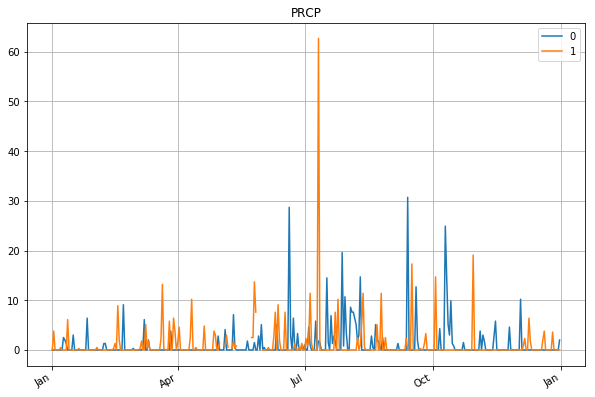

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[14:16,:].transpose(),fig,ax,title='PRCP') # plot PRCP for first 2 years in record, reading for all days, for 1 station
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func,factor=1.0):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis,factor)
        
def plot_valid(m,fig,axis,factor=1.0):
    valid_m=STAT[m]['NE']   ## count of values per day
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


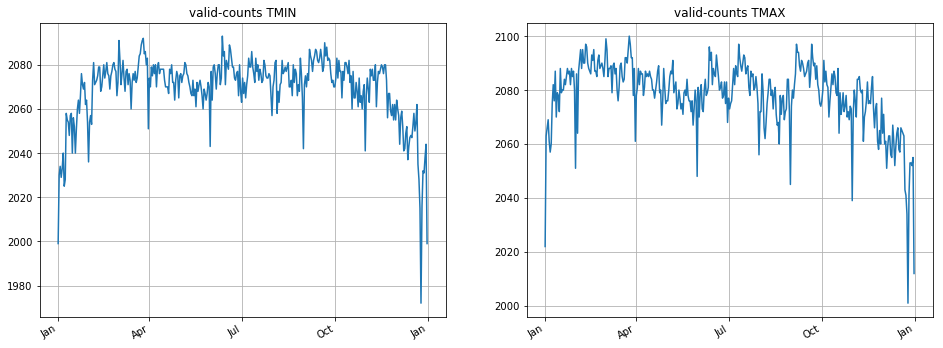

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid) ## avg over all the years??

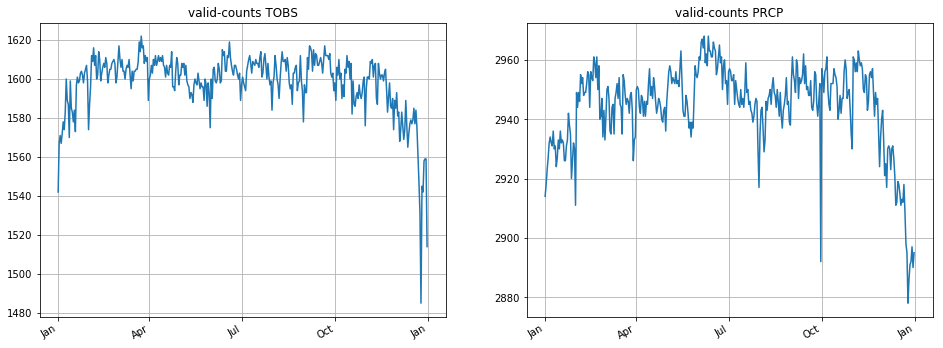

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

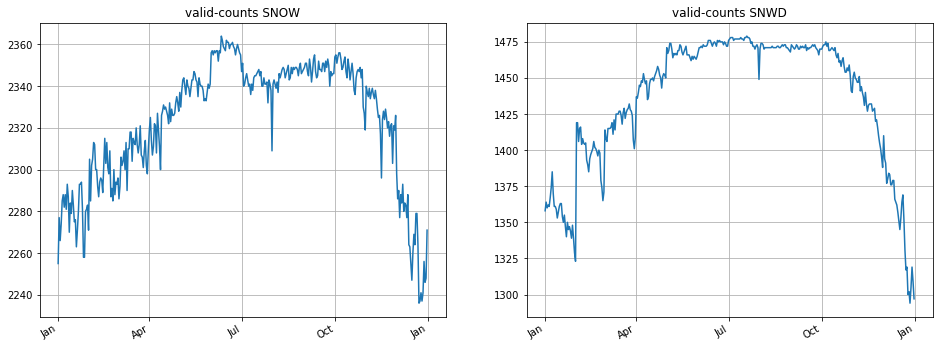

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis,factor=1.0):
    mean=STAT[m]['Mean']/factor
    print m, sum(mean)
    std=np.sqrt(STAT[m]['Var'])/factor
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    
def plot_mean(m,fig,axis,factor=1.0):
    mean=STAT[m]['Mean']/factor
    graphs=np.vstack([mean]).transpose()
    YP.plot(graphs,fig,axis,title='Mean   '+m)

TMIN 267.953845836
TMAX 6437.36511034


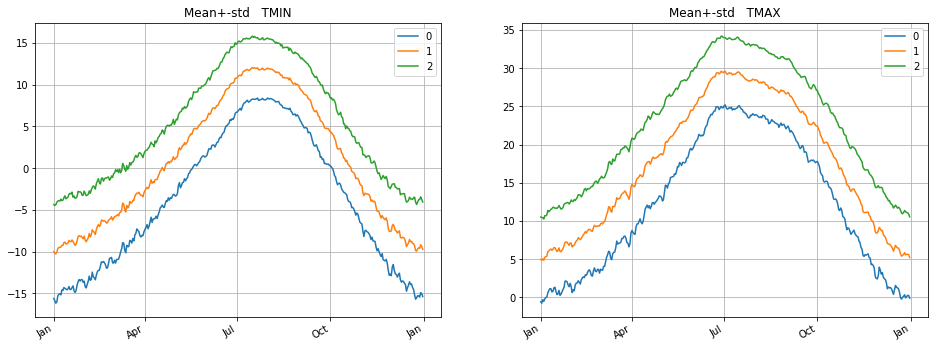

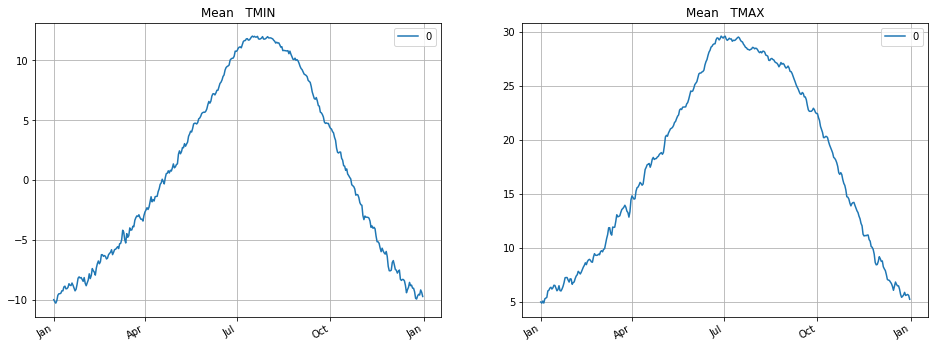

In [9]:
plot_pair(['TMIN','TMAX'],plot_mean_std, 10)

TOBS 3773.76164135
PRCP 364.064360921


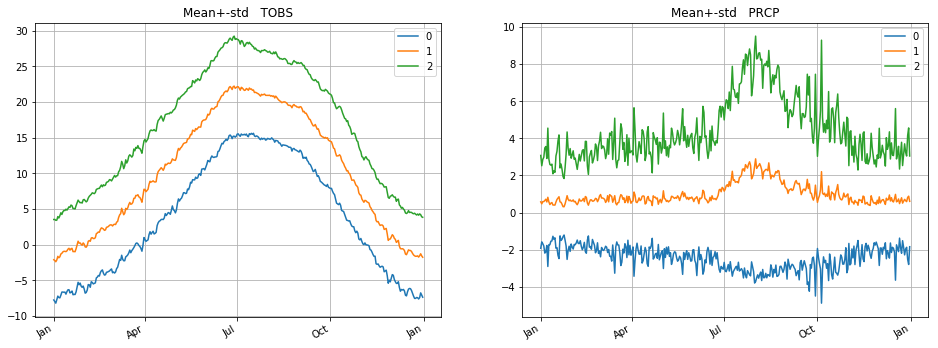

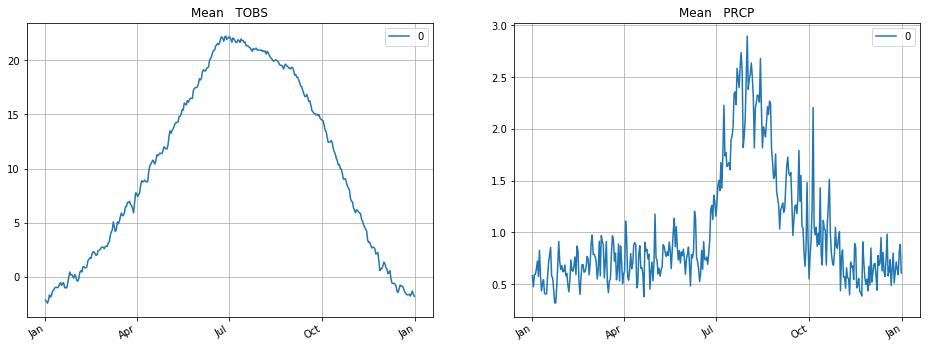

In [10]:
plot_pair(['TOBS','PRCP'],plot_mean_std,10)
plot_pair(['TOBS','PRCP'],plot_mean,10)

SNOW 730.104038629
SNWD 3882.78500786


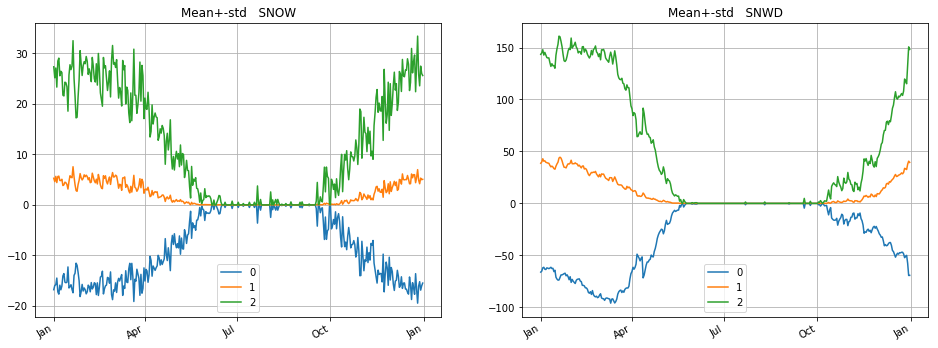

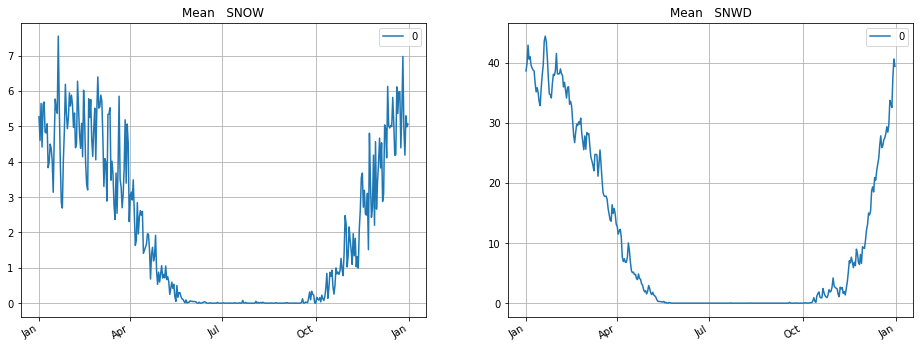

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
plot_pair(['SNOW', 'SNWD'],plot_mean)

### plotting top 3 eigenvectors

In [18]:
def plot_eigen(m,fig,axis,factor=1.0):
    #print STAT[m]['eigval']
    EV=STAT[m]['eigvec']
    #print STAT[m]['eigval']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

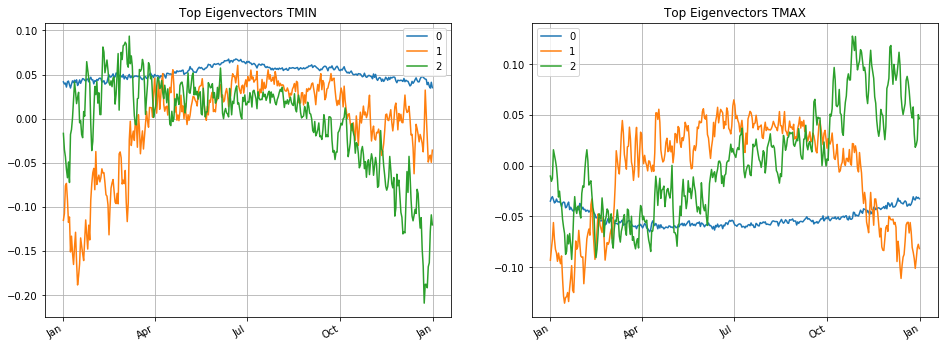

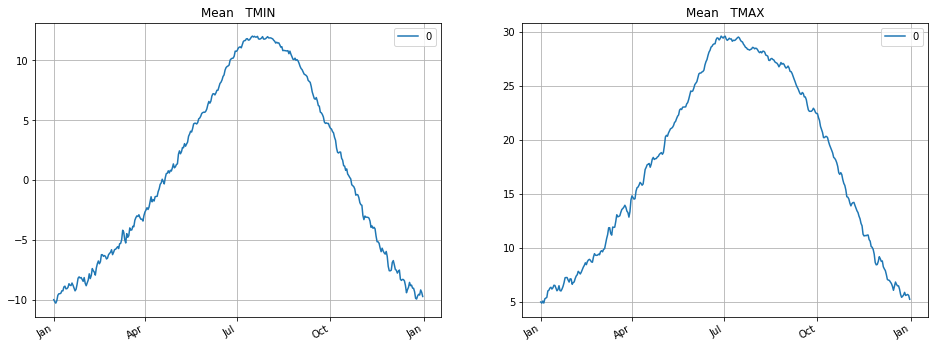

In [20]:
plot_pair(['TMIN','TMAX'],plot_eigen)
plot_pair(['TMIN','TMAX'],plot_mean, 10)

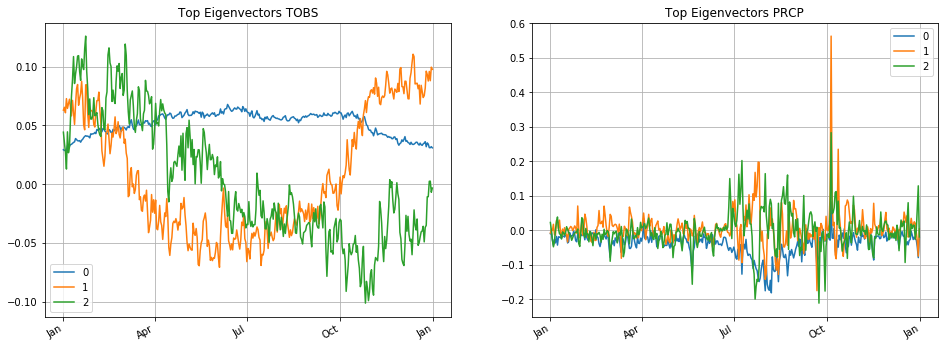

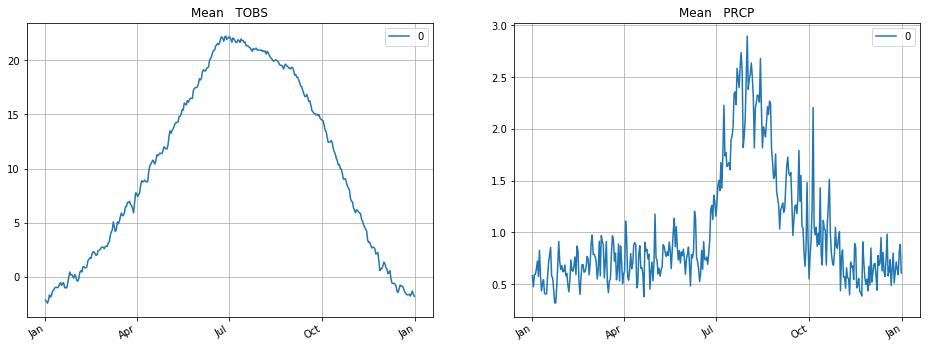

In [21]:
plot_pair(['TOBS','PRCP'],plot_eigen)
plot_pair(['TOBS','PRCP'],plot_mean, 10)

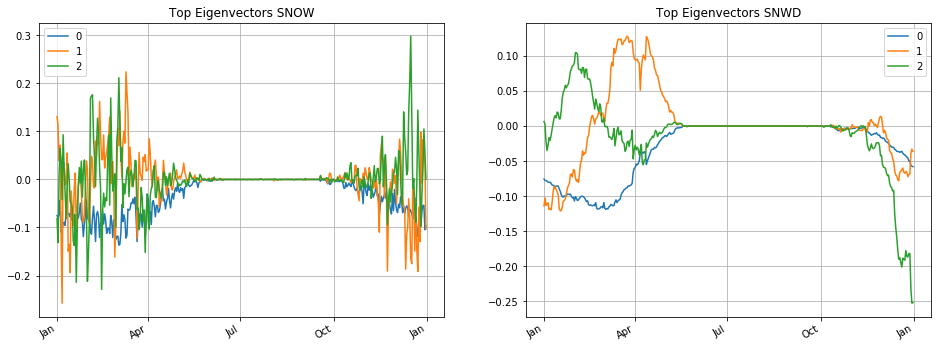

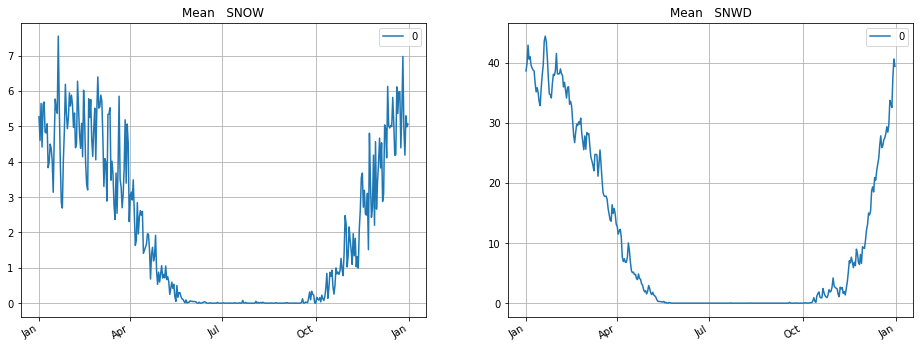

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)
plot_pair(['SNOW', 'SNWD'],plot_mean)

### Script for plotting percentage of variance explained

In [33]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

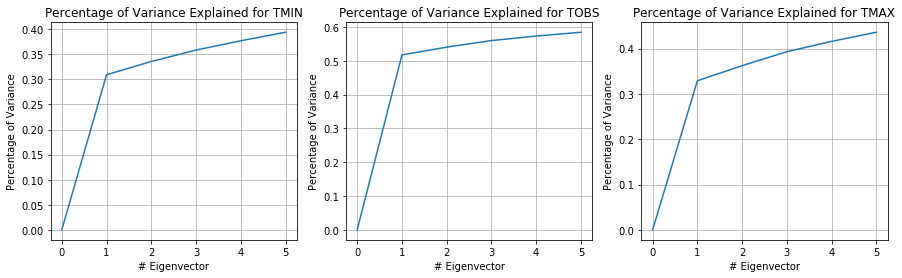

In [34]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

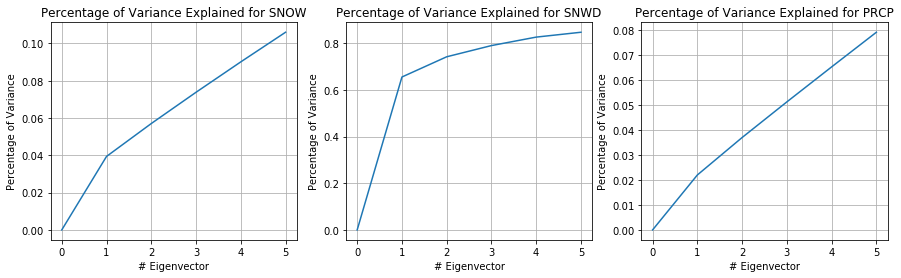

In [35]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [21]:
sc.stop()